**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several other sources, such as: [Lee Vaughan](https://towardsdatascience.com/voronoi-grids-a-practical-application-7e6ee3b1daf0). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions. 

# Voronoi Grids

Voronoi grids, also called Voronoi diagrams, are used to partition a plane into discrete regions around a given set of seed points. For each seed, there is a corresponding region, called a Voronoi cell, within which all points on the plane are closer to that seed than to any other.

For making Voronoi diagrams, SciPy provides the scipy.spatial.voronoi() class, which uses the Qhull library to compute the Voronoi grid. As mentioned previously, all the locations within a grid cell should be closer to the seed point used to generate that cell than to any other seed point.

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from scipy.spatial import Voronoi

In [ ]:
# Load the school locations CSV file into a DataFrame:
df = pd.read_csv('https://bit.ly/3MYYegT')

In [ ]:
# Create a GeoDataFrame with Point geometries:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['Longitude'],df['Latitude']), crs='EPSG:4326')

In [ ]:
# Create a Voronoi diagram using the GeoDataFrame.
# Use -1 to check for and exclude regions that extend to infinity:
vor = Voronoi(gdf[['Longitude', 'Latitude']])
voronoi_polygons = [Polygon(vor.vertices[region]) 
                    for region in vor.regions 
                    if region and -1 not in region]

# Create a GeoDataFrame with the Voronoi polygons:
gdf_voronoi = gpd.GeoDataFrame(geometry=voronoi_polygons,crs='EPSG:4326')

Because we’re not using all the primary schools in the area, many edge cells will be unconstrained and may extend for ridiculously long distances. To handle these, we’ll create a bounding box and use it to truncate any Voronoi cells (polygons) that extend beyond it.

In [ ]:
# Define the bounding box lat-lon limits:
max_lat, min_lat, max_lon, min_lon = (-37.75, -37.9, 145.18, 144.84)

# Create the bounding box as a Shapely Polygon
bounding_box = Polygon.from_bounds(min_lon, min_lat, max_lon, max_lat)

# Truncate each Voronoi polygon with the bounding box:
truncated_polygons = [polygon.intersection(bounding_box) for polygon in gdf_voronoi.geometry]

# Create a GeoDataFrame with the truncated polygons:
gdf_truncated = gpd.GeoDataFrame(geometry=truncated_polygons, crs='EPSG:4326')

In [ ]:
# Create a Folium map centered on the average coordinates of the schools:
map_center = [gdf['Latitude'].mean(), gdf['Longitude'].mean()]
school_map = folium.Map(location=map_center, zoom_start=12, tiles='OpenStreetMap')

# Plot the truncated Voronoi polygons on the map:
folium.GeoJson(gdf_truncated).add_to(school_map)

# Add markers for each school:
for index, school in gdf.iterrows():
    folium.Marker(location=[school['Latitude'], school['Longitude']],popup=f"{school['School']}\n\{school['Street Address']}\n{school['Town']}",icon=folium.Icon(color='blue', icon='home')).add_to(school_map)

# Save the map as an HTML file (optional):
# school_map.save('school_voronoi_map_truncated.html')

# Display the map in the notebook:
school_map

In [110]:
!pip install geovoronoi

For this project I create a voronoi diagram on the map based on data points (or point of interests), voronoi diagram have applications in almost all areas of science and engineering. For geospatial use case, it is useful to tell us the closest point of interest (POI) by representing each POI with a dot inside a polygon shape. So within a polygon, the closest POI is definitely the dot inside the polygon.

Ok, let's start the project. As usual, for the first step let's import all necessary packages

In [111]:
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Point, LineString, Polygon

In [112]:
colombia = colombia.to_crs(epsg=3116)    # convert to World Mercator CRS
area_shape = colombia.iloc[0].geometry   # get the Polygon

In [72]:
a=colombia.iloc[0].geometry
type(a)

shapely.geometry.polygon.Polygon

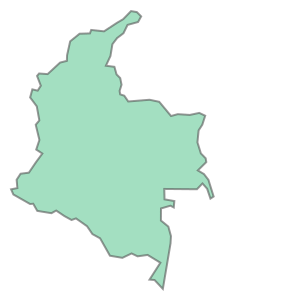

In [113]:
area_shape

<AxesSubplot:>

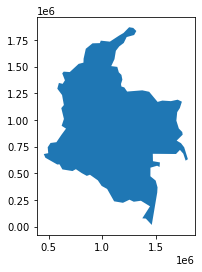

In [114]:
colombia.plot()

In [115]:
import numpy as np
coord = np.array([[750000,750000],[800000,1250000],[1000000,1500000],[1250000,500000],[1250000,1000000],[1300000,1100000],[1350000,1000000]])
coord

array([[ 750000,  750000],
       [ 800000, 1250000],
       [1000000, 1500000],
       [1250000,  500000],
       [1250000, 1000000],
       [1300000, 1100000],
       [1350000, 1000000]])

In [116]:
poly_shapes, pts= voronoi_regions_from_coords(coord, area_shape)

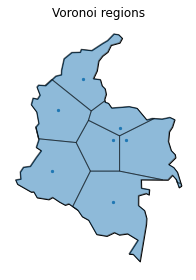

In [117]:
import matplotlib.pyplot as plt
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, area_shape, poly_shapes, coord)
ax.set_title('Voronoi regions')
plt.tight_layout()
plt.show()